# Сегментация сгенерированных кружочков

In [1]:
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
class BaseDataProvider(object):
    
    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, labels = self._next_data()
        train_data = self._process_data(data)
        nx = train_data.shape[1]
        ny = train_data.shape[0]
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx) 

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        if np.amax(data) != 0:
            data /= np.amax(data)
        return data

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny))
        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
        return X, Y


class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 1
    
    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
 
    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label


def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20):
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)
        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)
        image[m] = h
    label[mask, 1] = 1
    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    return image, label[..., 1]


def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb

In [4]:
generator = RgbDataProvider(512, 512, cnt=20)
img_train, mask_train = generator(500)
img_test, mask_test = generator(150)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [5]:
class ImgDataset(Dataset):

    def __init__(self, X, y, img_transform, mask_transform):
        self.X = X
        self.y = y
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        # https://github.com/pytorch/vision/issues/9#issuecomment-304224800
        seed = np.random.randint(2147483647)
        img = Image.fromarray(np.uint8(self.X[i]*255)).convert('RGB')  
        mask = Image.fromarray(np.uint8(self.y[i]))
        random.seed(seed)
        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        return img, torch.from_numpy(np.array(mask, dtype=np.int64))

    def __len__(self):
        return len(self.X)

In [6]:
class param:
    img_size = (80, 80)
    batch_size = 8
    num_workers = 4
    lr = 0.001
    epochs = 3
    unet_depth = 5
    unet_start_filters = 8

In [7]:
img_tfms = transforms.Compose([transforms.Resize(param.img_size),
                                 transforms.ToTensor()])
mask_tfms = transforms.Compose([transforms.Resize(param.img_size)])

In [8]:
train_ds = ImgDataset(img_train, mask_train, img_tfms, mask_tfms)
test_ds = ImgDataset(img_test, mask_test, img_tfms, mask_tfms)

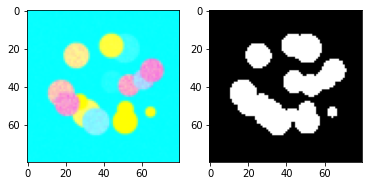

In [9]:
img, mask = train_ds[0]
plt.subplot(121)
plt.imshow(img.permute(1,2,0))
plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.show()

In [10]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [11]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [12]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

In [13]:
train_dl = DataLoader(train_ds,
                      batch_size=param.batch_size,
                      shuffle=True,
                      pin_memory=torch.cuda.is_available(),
                      num_workers=param.num_workers)
val_dl = DataLoader(test_ds,
                    batch_size=param.batch_size,
                    shuffle=False,
                    pin_memory=torch.cuda.is_available(),
                    num_workers=param.num_workers)

model = UNet(2,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat').to(device)
optim = torch.optim.Adam(model.parameters(), lr=param.lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [14]:
def get_loss(dl, model):
    loss = 0
    for X, y in dl:
        X, y = Variable(X).to(device), Variable(y).to(device)
        output = model(X)
        loss += F.cross_entropy(output, y).item()
    loss = loss / len(dl)
    return loss

In [16]:
iters = []
train_losses = []
val_losses = []

it = 0
min_loss = np.inf

model.train()
for epoch in range(param.epochs):
    for i, (X, y) in enumerate(train_dl):
        X = Variable(X).to(device)  # [N, 3, H, W]
        y = Variable(y).to(device)  # [N, H, W]
        output = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(output, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i + 1) % 5 == 0:
            it += 5 * param.batch_size
            iters.append(it)
            train_losses.append(loss.item())

            model.eval()
            val_loss = get_loss(val_dl, model)
            model.train()
            val_losses.append(val_loss)


model.eval()
val_loss = get_loss(val_dl, model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
df = pd.DataFrame([train_losses, val_losses], columns=iters).T
df.columns = ['train_loss', 'val_loss']
fig = px.line(df, width=800, height=400)
fig.show()

In [18]:
model.eval()
for X, masks in val_dl:
    X = X.to(device)
    output = model(X)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



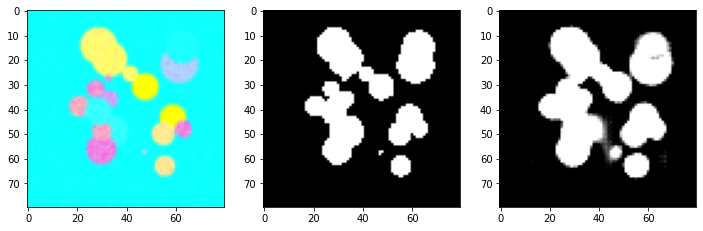

In [19]:
num_item = 5
image, mask, predicted = X[num_item], masks[num_item], np.clip(output[num_item, 1, ...].detach().cpu(), 0, 1)*255
plt.figure(figsize=(12,4))
plt.subplot(131) 
plt.imshow(image.permute(1,2,0).cpu())
plt.subplot(132)
plt.imshow(mask.cpu(), cmap='gray')
plt.subplot(133)
plt.imshow(predicted, cmap='gray')
plt.show()